In [1]:
# import geomloss

In [4]:
import pandas as pd
from sdv.single_table import TVAESynthesizer

from domias.evaluator import evaluate_performance
from domias.models.generator import GeneratorInterface
from domias.models.ctgan import CTGAN



from scipy import stats
from scipy.stats import multivariate_normal


import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, fetch_covtype, load_digits

import warnings
warnings.filterwarnings("ignore")

In [5]:
df_uci = pd.read_csv(r'C:\Users\jordy\OneDrive\MSc_Python\Individual_Project\Data\UCI_Credit_Card.csv')
df_uci.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
#convert dataframe to array
arr_uci = np.array(df_uci.iloc[:, 1:-1])
arr_uci.shape

(30000, 23)

In [7]:
def get_dataset() -> np.ndarray:
    def data_loader() -> np.ndarray:
        scaler = StandardScaler()
        X =arr_uci
        np.random.shuffle(X)
        return scaler.fit_transform(X)

    return data_loader()

In [8]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 10000 #held out set
training_epochs = [100, 500, 1000, 2000, 3000]
training_sizes = [10000]
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 200 #same as synthetic_sizes

method = "CTGAN"

# Create a dictionary to store the results
results = {}

# Set the number of iterations
num_iterations = 3

for iteration in range(1, num_iterations+1):
    # Initialize the result dictionary for the current iteration
    iteration_results = {}
    
    for training_size in training_sizes:
        # Initialize the result dictionary for the current training size
        size_results = {}
        
        for training_epoch in training_epochs:
            generator = get_generator(
                gan_method=method,
                epochs=training_epoch,
            )
    
            perf = evaluate_performance(
                generator,
                dataset,
                training_size,
                reference_set_size,
                training_epochs=training_epoch,
                synthetic_sizes=[gen_size],
                density_estimator=density_estimator,
            )
            
            # Store the MIA performance for the current training size and epoch
            size_results[training_epoch] = perf[gen_size]["MIA_performance"]
        
        # Store the results for the current training size
        iteration_results[training_size] = size_results
    
    # Store the results for the current iteration
    results[iteration] = iteration_results

# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for training_size, size_results in iteration_results.items():
        print(f"Training Size {training_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 175.346 -- validation_loss: 982.854
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 134.900 -- validation_loss: 969.393
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 97.296 -- validation_loss: 955.271
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 71.435 -- validation_loss: 940.703
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 52.171 -- validation_loss: 925.699
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 39.708 -- validation_loss: 910.424
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 31.210 -- validation_loss: 895.193
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 25.887 -- validation_loss: 880.270
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 21.447 -- validation_loss: 865.600
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 18.399 -- validation_loss: 851.242
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 15.528 -- validation_loss: 837.277
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 13.222 -- validation_loss: 823.694
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 11.305 -- validation_loss: 810.445
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 9.610 -- validation_loss: 797.525
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 8.278 -- validation_loss: 785.073
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 6.920 -- validation_loss: 772.921
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 5.549 -- validation_loss: 761.186
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 4.708 -- validation_loss: 749.769
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 3.580 -- validation_loss: 738.573
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 2.332 -- validation_loss: 727.760
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s, loss=2.85]


Epoch  21/ 50 -- train_loss: 1.580 -- validation_loss: 717.057
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.147 -- validation_loss: 706.597
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 0.867 -- validation_loss: 696.606
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s, loss=1.60]


Epoch  24/ 50 -- train_loss: -0.234 -- validation_loss: 686.866
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -0.429 -- validation_loss: 677.522
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s, loss=-3.81]


Epoch  26/ 50 -- train_loss: -0.790 -- validation_loss: 668.433
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -0.819 -- validation_loss: 659.531
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -2.337 -- validation_loss: 650.928
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -2.500 -- validation_loss: 642.401
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -3.439 -- validation_loss: 634.228
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -3.323 -- validation_loss: 626.266
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -3.384 -- validation_loss: 618.591
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -4.313 -- validation_loss: 611.026
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.405 -- validation_loss: 603.542
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s, loss=-2.76]


Epoch  35/ 50 -- train_loss: -5.302 -- validation_loss: 596.336
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -5.455 -- validation_loss: 589.446
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s, loss=-3.93]


Epoch  37/ 50 -- train_loss: -4.683 -- validation_loss: 582.706
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -5.288 -- validation_loss: 576.145
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -5.930 -- validation_loss: 569.555
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -5.523 -- validation_loss: 563.337
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s, loss=-5.95]


Epoch  41/ 50 -- train_loss: -5.755 -- validation_loss: 557.386
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -5.863 -- validation_loss: 551.661
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -5.570 -- validation_loss: 545.717
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -6.523 -- validation_loss: 540.052
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -7.155 -- validation_loss: 534.599
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s, loss=-7.86]


Epoch  46/ 50 -- train_loss: -7.975 -- validation_loss: 529.119
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -7.143 -- validation_loss: 523.597
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -8.444 -- validation_loss: 518.407
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s, loss=-9.37]


Epoch  49/ 50 -- train_loss: -8.659 -- validation_loss: 513.482
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s, loss=-8.70]


Epoch  50/ 50 -- train_loss: -8.570 -- validation_loss: 508.607
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 508.607
Test loss:       506.056
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 6.654 -- validation_loss: 503.723
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -16.497 -- validation_loss: 337.545
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -20.994 -- validation_loss: 232.897
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -24.122 -- validation_loss: 165.461
Saving model..


100%|████████████████████████████| 200/200 [01:22<00:00,  2.42it/s, loss=-24.06]


Epoch   5/ 50 -- train_loss: -25.229 -- validation_loss: 127.540
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -25.979 -- validation_loss: 107.000
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -28.119 -- validation_loss: 95.656
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -28.133 -- validation_loss: 88.926
Saving model..


100%|████████████████████████████| 200/200 [01:21<00:00,  2.44it/s, loss=-27.63]


Epoch   9/ 50 -- train_loss: -29.546 -- validation_loss: 84.910
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -30.795 -- validation_loss: 82.506
Saving model..


100%|████████████████████████████| 200/200 [01:18<00:00,  2.55it/s, loss=-30.24]


Epoch  11/ 50 -- train_loss: -31.640 -- validation_loss: 81.251
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -32.879 -- validation_loss: 80.738
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -34.083 -- validation_loss: 80.294
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -36.569 -- validation_loss: 80.579


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -37.242 -- validation_loss: 80.991


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -39.535 -- validation_loss: 82.149


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -40.141 -- validation_loss: 83.344


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -40.742 -- validation_loss: 84.198


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -41.778 -- validation_loss: 84.964


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -42.924 -- validation_loss: 85.802


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -42.951 -- validation_loss: 86.559


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -43.140 -- validation_loss: 87.104


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -43.674 -- validation_loss: 87.596


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -44.799 -- validation_loss: 87.991


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -45.426 -- validation_loss: 88.498


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -46.208 -- validation_loss: 88.879


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -46.047 -- validation_loss: 89.314


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -47.221 -- validation_loss: 89.864


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -46.856 -- validation_loss: 90.152


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -47.608 -- validation_loss: 90.639


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -47.645 -- validation_loss: 91.082


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -47.623 -- validation_loss: 91.128


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -48.674 -- validation_loss: 91.467


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -48.787 -- validation_loss: 91.708
Epoch 00034: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -55.405 -- validation_loss: 92.767


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -57.380 -- validation_loss: 94.086


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -56.851 -- validation_loss: 95.137


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -57.750 -- validation_loss: 95.849


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -58.040 -- validation_loss: 96.469


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -57.003 -- validation_loss: 96.831


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -57.301 -- validation_loss: 97.077


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -58.578 -- validation_loss: 97.392


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -57.839 -- validation_loss: 97.532


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -57.451 -- validation_loss: 97.704


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -58.370 -- validation_loss: 97.816


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -58.045 -- validation_loss: 98.021


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -57.724 -- validation_loss: 98.079


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -58.779 -- validation_loss: 98.152


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -57.185 -- validation_loss: 98.291


100%|████████████████████████████| 200/200 [01:19<00:00,  2.51it/s, loss=-59.14]


Epoch  50/ 50 -- train_loss: -58.949 -- validation_loss: 98.383
###### Stop training after 50 epochs!
Validation loss: 98.383
Test loss:       98.508


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 175.700 -- validation_loss: 981.205
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 135.873 -- validation_loss: 966.766
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 100.433 -- validation_loss: 951.843
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 79.068 -- validation_loss: 936.508
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 59.896 -- validation_loss: 920.944
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 45.619 -- validation_loss: 905.077
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 36.535 -- validation_loss: 889.504
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 29.565 -- validation_loss: 873.975
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 24.831 -- validation_loss: 858.950
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 21.541 -- validation_loss: 844.018
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 18.833 -- validation_loss: 829.517
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 15.825 -- validation_loss: 815.390
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 14.251 -- validation_loss: 801.629
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 12.241 -- validation_loss: 788.430
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 11.481 -- validation_loss: 775.651
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 9.662 -- validation_loss: 763.295
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 8.349 -- validation_loss: 751.273
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 7.152 -- validation_loss: 739.570
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 6.674 -- validation_loss: 728.175
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 5.627 -- validation_loss: 717.130
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 4.281 -- validation_loss: 706.434
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 3.286 -- validation_loss: 696.028
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 2.685 -- validation_loss: 686.077
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 2.227 -- validation_loss: 676.345
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 1.465 -- validation_loss: 666.856
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 1.024 -- validation_loss: 657.586
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 0.272 -- validation_loss: 648.663
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 0.008 -- validation_loss: 640.005
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -0.706 -- validation_loss: 631.574
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s, loss=-1.18]


Epoch  30/ 50 -- train_loss: -2.024 -- validation_loss: 623.304
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -2.286 -- validation_loss: 615.413
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -2.986 -- validation_loss: 607.663
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -3.401 -- validation_loss: 600.167
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -3.625 -- validation_loss: 592.865
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -3.739 -- validation_loss: 585.778
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -2.997 -- validation_loss: 578.909
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -3.629 -- validation_loss: 572.090
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -3.763 -- validation_loss: 565.537
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -3.844 -- validation_loss: 559.086
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -4.454 -- validation_loss: 552.797
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -5.272 -- validation_loss: 546.575
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -5.443 -- validation_loss: 540.675
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -5.924 -- validation_loss: 534.836
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -5.703 -- validation_loss: 529.153
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -6.634 -- validation_loss: 523.661
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -6.771 -- validation_loss: 518.157
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -5.881 -- validation_loss: 512.898
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -6.051 -- validation_loss: 507.661
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -5.680 -- validation_loss: 502.485
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s, loss=-3.75]


Epoch  50/ 50 -- train_loss: -5.497 -- validation_loss: 497.444
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 497.444
Test loss:       492.647
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 6.712 -- validation_loss: 501.849
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -13.960 -- validation_loss: 330.730
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -17.175 -- validation_loss: 231.699
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -20.650 -- validation_loss: 170.299
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -24.329 -- validation_loss: 134.538
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -26.292 -- validation_loss: 114.410
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -28.615 -- validation_loss: 103.645
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -29.830 -- validation_loss: 97.891
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -31.388 -- validation_loss: 94.950
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -31.705 -- validation_loss: 93.374
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -33.740 -- validation_loss: 92.867
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -35.524 -- validation_loss: 92.982


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -34.951 -- validation_loss: 93.087


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -36.534 -- validation_loss: 93.606


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -37.374 -- validation_loss: 94.165


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -38.880 -- validation_loss: 94.849


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -39.955 -- validation_loss: 95.860


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -41.358 -- validation_loss: 96.924


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -41.475 -- validation_loss: 97.896


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -42.789 -- validation_loss: 99.011


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -43.277 -- validation_loss: 100.145


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -44.937 -- validation_loss: 101.406


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -43.820 -- validation_loss: 102.128


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -45.279 -- validation_loss: 102.746


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -45.879 -- validation_loss: 103.634


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -46.120 -- validation_loss: 104.493


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -47.910 -- validation_loss: 105.551


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -46.620 -- validation_loss: 106.157


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -47.811 -- validation_loss: 106.670


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -48.078 -- validation_loss: 107.263


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -48.311 -- validation_loss: 107.779


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -49.449 -- validation_loss: 108.586
Epoch 00032: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -56.766 -- validation_loss: 110.072


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -58.447 -- validation_loss: 111.714


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -57.849 -- validation_loss: 112.916


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -59.520 -- validation_loss: 113.926


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -58.423 -- validation_loss: 114.686


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -58.799 -- validation_loss: 115.270


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -58.575 -- validation_loss: 115.709


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -59.304 -- validation_loss: 116.007


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -58.613 -- validation_loss: 116.280


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -58.517 -- validation_loss: 116.453


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -60.183 -- validation_loss: 116.559


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -60.059 -- validation_loss: 116.821


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -59.246 -- validation_loss: 117.072


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -60.672 -- validation_loss: 117.288


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -59.102 -- validation_loss: 117.506


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -60.436 -- validation_loss: 117.671


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -60.599 -- validation_loss: 117.834


100%|████████████████████████████| 200/200 [01:12<00:00,  2.76it/s, loss=-59.73]


Epoch  50/ 50 -- train_loss: -59.693 -- validation_loss: 117.969
###### Stop training after 50 epochs!
Validation loss: 117.969
Test loss:       117.858


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 191.216 -- validation_loss: 981.104
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 143.488 -- validation_loss: 966.190
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 108.465 -- validation_loss: 950.436
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 80.484 -- validation_loss: 934.236
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 61.637 -- validation_loss: 917.703
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 48.270 -- validation_loss: 901.215
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 40.462 -- validation_loss: 885.001
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 34.196 -- validation_loss: 869.146
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 29.788 -- validation_loss: 853.667
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 25.873 -- validation_loss: 838.610
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 22.628 -- validation_loss: 823.704
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 19.107 -- validation_loss: 809.753
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 17.056 -- validation_loss: 796.182
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 15.195 -- validation_loss: 783.004
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 13.438 -- validation_loss: 770.337
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 11.837 -- validation_loss: 758.064
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 10.036 -- validation_loss: 746.326
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 8.676 -- validation_loss: 734.857
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 9.479 -- validation_loss: 723.664
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 8.141 -- validation_loss: 712.788
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 6.839 -- validation_loss: 702.448
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 6.037 -- validation_loss: 692.292
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 5.597 -- validation_loss: 682.520
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 5.201 -- validation_loss: 672.934
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 4.838 -- validation_loss: 663.684
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 4.091 -- validation_loss: 654.826
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 3.767 -- validation_loss: 646.139
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 3.231 -- validation_loss: 637.691
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 3.410 -- validation_loss: 629.634
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: 2.050 -- validation_loss: 621.648
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: 1.787 -- validation_loss: 613.809
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 0.979 -- validation_loss: 606.486
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -0.229 -- validation_loss: 599.272
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: 0.493 -- validation_loss: 592.367
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 0.834 -- validation_loss: 585.510
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 1.566 -- validation_loss: 578.654
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 0.811 -- validation_loss: 572.078
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 0.030 -- validation_loss: 565.836
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: 0.061 -- validation_loss: 559.490
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -0.556 -- validation_loss: 553.568
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: 0.110 -- validation_loss: 547.814
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -1.246 -- validation_loss: 542.122
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -2.715 -- validation_loss: 536.652
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -3.257 -- validation_loss: 531.454
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -2.934 -- validation_loss: 526.189
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -4.024 -- validation_loss: 521.070
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -4.041 -- validation_loss: 516.018
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -4.344 -- validation_loss: 511.064
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -2.843 -- validation_loss: 505.975
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s, loss=-2.95]


Epoch  50/ 50 -- train_loss: -2.013 -- validation_loss: 501.102
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 501.102
Test loss:       502.686
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 12.841 -- validation_loss: 508.982
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -13.150 -- validation_loss: 344.512
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -17.110 -- validation_loss: 237.988
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -19.754 -- validation_loss: 171.362
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -21.099 -- validation_loss: 131.741
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -22.525 -- validation_loss: 108.599
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -23.223 -- validation_loss: 95.357
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -23.618 -- validation_loss: 87.392
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -26.649 -- validation_loss: 82.692
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -27.734 -- validation_loss: 80.094
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -28.208 -- validation_loss: 78.309
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -30.340 -- validation_loss: 77.435
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -31.387 -- validation_loss: 76.885
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -32.095 -- validation_loss: 76.595
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -33.143 -- validation_loss: 76.771


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -33.686 -- validation_loss: 76.831


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -35.118 -- validation_loss: 76.864


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -37.201 -- validation_loss: 77.295


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -36.499 -- validation_loss: 77.555


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -37.574 -- validation_loss: 77.900


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -37.353 -- validation_loss: 78.248


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -37.878 -- validation_loss: 78.492


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -39.305 -- validation_loss: 78.858


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -39.298 -- validation_loss: 79.137


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -40.436 -- validation_loss: 79.435


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -39.680 -- validation_loss: 79.722


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -40.910 -- validation_loss: 80.006


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -42.014 -- validation_loss: 80.304


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -42.491 -- validation_loss: 80.554


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -43.540 -- validation_loss: 80.857


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -43.452 -- validation_loss: 81.109


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -42.722 -- validation_loss: 81.443


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -44.953 -- validation_loss: 81.891


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -43.851 -- validation_loss: 81.988


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -42.047 -- validation_loss: 82.085
Epoch 00035: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -51.188 -- validation_loss: 82.928


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -50.274 -- validation_loss: 83.835


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -52.504 -- validation_loss: 84.704


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -51.756 -- validation_loss: 85.344


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -52.319 -- validation_loss: 85.887


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -52.854 -- validation_loss: 86.182


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -52.689 -- validation_loss: 86.506


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -50.007 -- validation_loss: 86.605


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -50.933 -- validation_loss: 86.709


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -52.064 -- validation_loss: 86.825


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -52.338 -- validation_loss: 86.862


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -52.853 -- validation_loss: 86.920


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -53.712 -- validation_loss: 87.028


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -52.965 -- validation_loss: 87.062


100%|████████████████████████████| 200/200 [01:12<00:00,  2.75it/s, loss=-51.07]


Epoch  50/ 50 -- train_loss: -54.534 -- validation_loss: 87.260
###### Stop training after 50 epochs!
Validation loss: 87.260
Test loss:       87.124


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 169.767 -- validation_loss: 981.767
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 130.313 -- validation_loss: 967.657
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 100.561 -- validation_loss: 953.064
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 76.210 -- validation_loss: 938.209
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 57.798 -- validation_loss: 923.172
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 42.467 -- validation_loss: 908.177
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 34.196 -- validation_loss: 893.222
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 27.795 -- validation_loss: 878.426
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 23.980 -- validation_loss: 863.923
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 20.395 -- validation_loss: 849.793
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 17.256 -- validation_loss: 836.027
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 13.631 -- validation_loss: 822.594
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 11.365 -- validation_loss: 809.518
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 8.860 -- validation_loss: 796.834
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 7.394 -- validation_loss: 784.536
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 5.636 -- validation_loss: 772.563
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 4.353 -- validation_loss: 760.915
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 3.409 -- validation_loss: 749.733
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 2.263 -- validation_loss: 738.775
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 1.594 -- validation_loss: 728.224
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 0.422 -- validation_loss: 717.900
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -0.009 -- validation_loss: 707.846
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -1.268 -- validation_loss: 698.189
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -1.622 -- validation_loss: 688.709
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -1.871 -- validation_loss: 679.511
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -2.223 -- validation_loss: 670.724
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -2.492 -- validation_loss: 662.029
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -2.627 -- validation_loss: 653.759
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -3.522 -- validation_loss: 645.543
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -3.023 -- validation_loss: 637.703
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -2.994 -- validation_loss: 630.067
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -2.236 -- validation_loss: 622.541
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -4.130 -- validation_loss: 615.151
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.421 -- validation_loss: 608.116
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -4.663 -- validation_loss: 601.111
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -5.638 -- validation_loss: 594.249
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -5.394 -- validation_loss: 587.727
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -6.040 -- validation_loss: 581.294
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -6.601 -- validation_loss: 575.034
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -7.181 -- validation_loss: 568.914
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -7.225 -- validation_loss: 563.013
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -6.888 -- validation_loss: 557.332
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -7.546 -- validation_loss: 551.700
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -8.166 -- validation_loss: 546.169
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -8.331 -- validation_loss: 540.744
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -8.731 -- validation_loss: 535.369
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -9.857 -- validation_loss: 530.229
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -9.263 -- validation_loss: 525.186
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -9.674 -- validation_loss: 520.258
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s, loss=-8.76]


Epoch  50/ 50 -- train_loss: -9.351 -- validation_loss: 515.351
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 515.351
Test loss:       519.274
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 8.858 -- validation_loss: 534.766
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -15.309 -- validation_loss: 362.490
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -18.352 -- validation_loss: 252.878
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -21.581 -- validation_loss: 182.722
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -23.403 -- validation_loss: 141.334
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -25.655 -- validation_loss: 118.108
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -25.940 -- validation_loss: 104.493
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -26.544 -- validation_loss: 96.069
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -28.737 -- validation_loss: 91.143
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -30.539 -- validation_loss: 88.006
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -32.678 -- validation_loss: 86.132
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -34.303 -- validation_loss: 85.102
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -35.174 -- validation_loss: 84.570
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -36.070 -- validation_loss: 84.420
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -37.846 -- validation_loss: 84.732


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -38.529 -- validation_loss: 85.076


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -39.593 -- validation_loss: 85.750


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -40.314 -- validation_loss: 86.518


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -40.854 -- validation_loss: 87.265


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -41.466 -- validation_loss: 87.930


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -41.150 -- validation_loss: 88.490


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -42.967 -- validation_loss: 89.251


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -42.783 -- validation_loss: 89.837


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -43.964 -- validation_loss: 90.529


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -43.520 -- validation_loss: 91.104


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -44.323 -- validation_loss: 91.732


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -44.336 -- validation_loss: 92.246


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -43.275 -- validation_loss: 92.445


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -46.250 -- validation_loss: 93.142


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -45.089 -- validation_loss: 93.748


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -46.295 -- validation_loss: 94.072


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -46.843 -- validation_loss: 94.669


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -46.708 -- validation_loss: 95.210


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -46.845 -- validation_loss: 95.546


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -47.648 -- validation_loss: 96.127
Epoch 00035: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -54.792 -- validation_loss: 97.404


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -56.649 -- validation_loss: 98.947


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -56.036 -- validation_loss: 100.091


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -56.203 -- validation_loss: 100.944


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -56.738 -- validation_loss: 101.595


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -57.119 -- validation_loss: 102.119


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -57.145 -- validation_loss: 102.597


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -56.826 -- validation_loss: 102.913


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -57.875 -- validation_loss: 103.153


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -58.143 -- validation_loss: 103.445


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -57.450 -- validation_loss: 103.718


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -57.490 -- validation_loss: 103.925


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -58.648 -- validation_loss: 104.122


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -57.608 -- validation_loss: 104.322


100%|████████████████████████████| 200/200 [01:12<00:00,  2.76it/s, loss=-63.87]


Epoch  50/ 50 -- train_loss: -57.936 -- validation_loss: 104.468
###### Stop training after 50 epochs!
Validation loss: 104.468
Test loss:       104.199


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s, loss=150.70]


Epoch   1/ 50 -- train_loss: 171.562 -- validation_loss: 983.623
Saving model..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=108.72]


Epoch   2/ 50 -- train_loss: 124.684 -- validation_loss: 970.367
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=77.61]


Epoch   3/ 50 -- train_loss: 88.957 -- validation_loss: 956.462
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=51.29]


Epoch   4/ 50 -- train_loss: 60.056 -- validation_loss: 942.199
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=45.06]


Epoch   5/ 50 -- train_loss: 45.563 -- validation_loss: 927.523
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=33.78]


Epoch   6/ 50 -- train_loss: 36.043 -- validation_loss: 912.753
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=28.29]


Epoch   7/ 50 -- train_loss: 29.807 -- validation_loss: 897.889
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=23.41]


Epoch   8/ 50 -- train_loss: 24.867 -- validation_loss: 883.222
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s, loss=19.87]


Epoch   9/ 50 -- train_loss: 20.162 -- validation_loss: 868.573
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 17.346 -- validation_loss: 854.326
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=12.82]


Epoch  11/ 50 -- train_loss: 14.679 -- validation_loss: 840.222
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 12.875 -- validation_loss: 826.582
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=11.35]


Epoch  13/ 50 -- train_loss: 11.029 -- validation_loss: 813.374
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=11.94]


Epoch  14/ 50 -- train_loss: 9.552 -- validation_loss: 800.615
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=10.14]


Epoch  15/ 50 -- train_loss: 8.105 -- validation_loss: 788.143
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s, loss=8.09]


Epoch  16/ 50 -- train_loss: 6.431 -- validation_loss: 775.938
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=0.65]


Epoch  17/ 50 -- train_loss: 5.134 -- validation_loss: 764.074
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s, loss=3.40]


Epoch  18/ 50 -- train_loss: 3.870 -- validation_loss: 752.566
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 2.970 -- validation_loss: 741.299
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s, loss=1.72]


Epoch  20/ 50 -- train_loss: 2.381 -- validation_loss: 730.396
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s, loss=4.70]


Epoch  21/ 50 -- train_loss: 1.382 -- validation_loss: 719.888
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 0.280 -- validation_loss: 709.725
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s, loss=-1.17]


Epoch  23/ 50 -- train_loss: -0.883 -- validation_loss: 699.720
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s, loss=-1.00]


Epoch  24/ 50 -- train_loss: -1.816 -- validation_loss: 690.042
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s, loss=-2.94]


Epoch  25/ 50 -- train_loss: -2.106 -- validation_loss: 680.765
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s, loss=-4.41]


Epoch  26/ 50 -- train_loss: -3.243 -- validation_loss: 671.755
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s, loss=-4.41]


Epoch  27/ 50 -- train_loss: -3.682 -- validation_loss: 663.103
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -3.393 -- validation_loss: 654.645
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-4.80]


Epoch  29/ 50 -- train_loss: -4.794 -- validation_loss: 646.372
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -4.893 -- validation_loss: 638.395
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -4.604 -- validation_loss: 630.588
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s, loss=-6.78]


Epoch  32/ 50 -- train_loss: -5.370 -- validation_loss: 623.113
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s, loss=-6.98]


Epoch  33/ 50 -- train_loss: -5.626 -- validation_loss: 615.902
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -5.643 -- validation_loss: 608.770
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -6.103 -- validation_loss: 601.827
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s, loss=-7.21]


Epoch  36/ 50 -- train_loss: -6.380 -- validation_loss: 595.091
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s, loss=-6.73]


Epoch  37/ 50 -- train_loss: -7.271 -- validation_loss: 588.456
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-5.77]


Epoch  38/ 50 -- train_loss: -7.135 -- validation_loss: 582.057
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -7.897 -- validation_loss: 575.740
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -8.145 -- validation_loss: 569.622
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s, loss=-8.55]


Epoch  41/ 50 -- train_loss: -8.331 -- validation_loss: 563.723
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s, loss=-9.05]


Epoch  42/ 50 -- train_loss: -8.200 -- validation_loss: 557.798
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -8.293 -- validation_loss: 552.110
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-7.01]


Epoch  44/ 50 -- train_loss: -8.548 -- validation_loss: 546.453
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=-9.89]


Epoch  45/ 50 -- train_loss: -9.325 -- validation_loss: 541.056
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-9.48]


Epoch  46/ 50 -- train_loss: -9.843 -- validation_loss: 535.720
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s, loss=-6.77]


Epoch  47/ 50 -- train_loss: -9.313 -- validation_loss: 530.588
Saving model..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=-10.84]


Epoch  48/ 50 -- train_loss: -9.683 -- validation_loss: 525.507
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -9.327 -- validation_loss: 520.595
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s, loss=-8.26]


Epoch  50/ 50 -- train_loss: -8.867 -- validation_loss: 515.734
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 515.734
Test loss:       512.844
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|█████████████████████████████| 200/200 [01:38<00:00,  2.04it/s, loss=-6.49]


Epoch   1/ 50 -- train_loss: 15.846 -- validation_loss: 523.782
Saving model..


100%|████████████████████████████| 200/200 [01:37<00:00,  2.05it/s, loss=-13.40]


Epoch   2/ 50 -- train_loss: -10.955 -- validation_loss: 364.304
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.01it/s, loss=-16.52]


Epoch   3/ 50 -- train_loss: -15.181 -- validation_loss: 259.284
Saving model..


100%|████████████████████████████| 200/200 [01:41<00:00,  1.97it/s, loss=-15.55]


Epoch   4/ 50 -- train_loss: -17.515 -- validation_loss: 187.394
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.01it/s, loss=-21.00]


Epoch   5/ 50 -- train_loss: -19.398 -- validation_loss: 142.115
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -21.344 -- validation_loss: 115.206
Saving model..


100%|████████████████████████████| 200/200 [01:40<00:00,  2.00it/s, loss=-22.84]


Epoch   7/ 50 -- train_loss: -24.222 -- validation_loss: 99.580
Saving model..


100%|████████████████████████████| 200/200 [01:42<00:00,  1.95it/s, loss=-27.88]


Epoch   8/ 50 -- train_loss: -23.271 -- validation_loss: 89.949
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.02it/s, loss=-32.23]


Epoch   9/ 50 -- train_loss: -26.247 -- validation_loss: 84.243
Saving model..


100%|████████████████████████████| 200/200 [01:55<00:00,  1.74it/s, loss=-30.76]


Epoch  10/ 50 -- train_loss: -27.992 -- validation_loss: 81.028
Saving model..


100%|████████████████████████████| 200/200 [01:42<00:00,  1.95it/s, loss=-27.85]


Epoch  11/ 50 -- train_loss: -29.999 -- validation_loss: 79.024
Saving model..


100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s, loss=-30.32]


Epoch  12/ 50 -- train_loss: -31.326 -- validation_loss: 77.956
Saving model..


100%|████████████████████████████| 200/200 [01:38<00:00,  2.03it/s, loss=-36.47]


Epoch  13/ 50 -- train_loss: -33.263 -- validation_loss: 77.375
Saving model..


100%|████████████████████████████| 200/200 [01:43<00:00,  1.94it/s, loss=-35.87]


Epoch  14/ 50 -- train_loss: -33.582 -- validation_loss: 77.247
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -34.275 -- validation_loss: 77.391


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -34.314 -- validation_loss: 77.684


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -34.294 -- validation_loss: 77.852


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -34.466 -- validation_loss: 77.848


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -35.700 -- validation_loss: 78.039


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -36.390 -- validation_loss: 78.354


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -36.455 -- validation_loss: 78.667


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -37.332 -- validation_loss: 78.814


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -38.949 -- validation_loss: 78.969


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -38.142 -- validation_loss: 79.154


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -38.703 -- validation_loss: 79.325


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -39.522 -- validation_loss: 79.580


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -40.267 -- validation_loss: 79.965


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -39.441 -- validation_loss: 79.948


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -41.159 -- validation_loss: 80.095


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -40.673 -- validation_loss: 80.323


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -40.364 -- validation_loss: 80.467


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -40.168 -- validation_loss: 80.660


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -40.839 -- validation_loss: 80.797


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -40.397 -- validation_loss: 80.863


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -42.374 -- validation_loss: 81.368
Epoch 00035: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -47.547 -- validation_loss: 82.290


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -47.937 -- validation_loss: 83.256


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -49.041 -- validation_loss: 83.975


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -46.515 -- validation_loss: 84.228


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -48.762 -- validation_loss: 84.474


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -48.512 -- validation_loss: 84.662


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -48.254 -- validation_loss: 84.782


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -48.248 -- validation_loss: 84.815


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -48.432 -- validation_loss: 84.932


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -49.435 -- validation_loss: 85.042


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -47.525 -- validation_loss: 85.021


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -49.432 -- validation_loss: 85.100


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -47.893 -- validation_loss: 85.101


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -48.140 -- validation_loss: 85.091


100%|████████████████████████████| 200/200 [01:15<00:00,  2.64it/s, loss=-45.20]


Epoch  50/ 50 -- train_loss: -47.425 -- validation_loss: 85.044
###### Stop training after 50 epochs!
Validation loss: 85.044
Test loss:       85.366


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 192.775 -- validation_loss: 982.600
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 143.399 -- validation_loss: 968.652
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 105.617 -- validation_loss: 954.260
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 80.051 -- validation_loss: 939.534
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 60.644 -- validation_loss: 924.608
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 47.853 -- validation_loss: 909.414
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 38.039 -- validation_loss: 894.617
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 30.834 -- validation_loss: 879.742
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 26.135 -- validation_loss: 865.198
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 22.083 -- validation_loss: 850.993
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 18.656 -- validation_loss: 837.159
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 15.040 -- validation_loss: 823.638
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 12.529 -- validation_loss: 810.588
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 10.165 -- validation_loss: 797.900
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 9.350 -- validation_loss: 785.627
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 7.386 -- validation_loss: 773.737
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 5.916 -- validation_loss: 762.162
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 4.306 -- validation_loss: 750.914
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 3.198 -- validation_loss: 739.960
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 2.590 -- validation_loss: 729.311
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 1.328 -- validation_loss: 719.165
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.054 -- validation_loss: 709.309
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 0.400 -- validation_loss: 699.671
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -0.336 -- validation_loss: 690.285
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -1.425 -- validation_loss: 681.188
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -1.715 -- validation_loss: 672.551
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -2.174 -- validation_loss: 664.060
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -3.142 -- validation_loss: 655.749
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -2.894 -- validation_loss: 647.660
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -3.863 -- validation_loss: 640.004
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -4.053 -- validation_loss: 632.434
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -4.821 -- validation_loss: 625.058
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -5.135 -- validation_loss: 617.804
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.920 -- validation_loss: 610.849
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -5.006 -- validation_loss: 603.920
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -4.598 -- validation_loss: 597.299
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -5.158 -- validation_loss: 590.884
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -5.879 -- validation_loss: 584.643
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -5.681 -- validation_loss: 578.405
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -7.209 -- validation_loss: 572.545
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -6.621 -- validation_loss: 566.491
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -7.067 -- validation_loss: 560.946
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -7.687 -- validation_loss: 555.637
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -7.738 -- validation_loss: 550.146
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -7.959 -- validation_loss: 545.073
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -8.489 -- validation_loss: 540.027
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -9.281 -- validation_loss: 535.002
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -9.051 -- validation_loss: 530.077
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -9.285 -- validation_loss: 525.193
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s, loss=-7.91]


Epoch  50/ 50 -- train_loss: -9.411 -- validation_loss: 520.522
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 520.522
Test loss:       520.943
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 21.929 -- validation_loss: 533.681
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -9.516 -- validation_loss: 374.743
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -15.401 -- validation_loss: 270.545
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -19.120 -- validation_loss: 198.302
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -22.033 -- validation_loss: 151.999
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -24.467 -- validation_loss: 123.285
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -26.505 -- validation_loss: 105.385
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -29.133 -- validation_loss: 94.786
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -29.356 -- validation_loss: 88.271
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -29.639 -- validation_loss: 84.529
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -29.974 -- validation_loss: 81.978
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -30.927 -- validation_loss: 80.609
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -32.314 -- validation_loss: 79.990
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -32.546 -- validation_loss: 79.467
Saving model..


100%|████████████████████████████| 200/200 [01:12<00:00,  2.75it/s, loss=-33.75]


Epoch  15/ 50 -- train_loss: -34.134 -- validation_loss: 79.344
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -34.629 -- validation_loss: 79.406


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -34.785 -- validation_loss: 79.419


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -34.714 -- validation_loss: 79.473


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -33.648 -- validation_loss: 79.462


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -35.702 -- validation_loss: 79.464


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -36.526 -- validation_loss: 79.519


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -34.776 -- validation_loss: 79.843


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -34.839 -- validation_loss: 80.064


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -33.510 -- validation_loss: 79.749


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -36.133 -- validation_loss: 79.988


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -33.684 -- validation_loss: 79.586


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -35.697 -- validation_loss: 79.639


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -37.737 -- validation_loss: 80.000


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -37.929 -- validation_loss: 80.064


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -36.797 -- validation_loss: 80.139


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -37.861 -- validation_loss: 80.397


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -38.810 -- validation_loss: 80.567


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -37.851 -- validation_loss: 80.571


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -38.892 -- validation_loss: 80.800


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -38.850 -- validation_loss: 81.097


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -40.956 -- validation_loss: 81.670
Epoch 00036: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -46.107 -- validation_loss: 82.664


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -48.415 -- validation_loss: 83.874


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -47.638 -- validation_loss: 84.770


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -48.306 -- validation_loss: 85.372


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -47.665 -- validation_loss: 85.786


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -48.831 -- validation_loss: 86.139


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -48.136 -- validation_loss: 86.354


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -47.972 -- validation_loss: 86.385


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -48.476 -- validation_loss: 86.452


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -48.991 -- validation_loss: 86.703


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -49.473 -- validation_loss: 86.972


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -48.058 -- validation_loss: 87.152


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -49.230 -- validation_loss: 87.361


100%|████████████████████████████| 200/200 [01:12<00:00,  2.75it/s, loss=-45.86]


Epoch  50/ 50 -- train_loss: -50.970 -- validation_loss: 87.633
###### Stop training after 50 epochs!
Validation loss: 87.633
Test loss:       87.318


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 163.882 -- validation_loss: 977.195
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 123.302 -- validation_loss: 959.024
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 96.944 -- validation_loss: 940.761
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 78.949 -- validation_loss: 922.591
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 61.957 -- validation_loss: 904.594
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 50.326 -- validation_loss: 887.021
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 42.550 -- validation_loss: 869.955
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 37.308 -- validation_loss: 853.372
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 33.160 -- validation_loss: 837.371
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 30.228 -- validation_loss: 821.980
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 27.320 -- validation_loss: 807.283
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 25.087 -- validation_loss: 793.154
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 23.118 -- validation_loss: 779.486
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 22.025 -- validation_loss: 766.313
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 20.166 -- validation_loss: 753.628
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 19.861 -- validation_loss: 741.418
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 19.356 -- validation_loss: 729.557
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 18.136 -- validation_loss: 718.029
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 16.925 -- validation_loss: 706.810
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 15.943 -- validation_loss: 695.890
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 15.249 -- validation_loss: 685.411
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 14.594 -- validation_loss: 675.169
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 13.617 -- validation_loss: 665.273
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 13.496 -- validation_loss: 655.667
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 12.227 -- validation_loss: 646.468
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 12.350 -- validation_loss: 637.497
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 11.356 -- validation_loss: 628.793
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 11.031 -- validation_loss: 620.301
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 10.061 -- validation_loss: 611.971
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: 9.041 -- validation_loss: 603.951
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: 9.280 -- validation_loss: 596.245
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 9.502 -- validation_loss: 588.793
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 7.497 -- validation_loss: 581.444
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: 6.498 -- validation_loss: 574.332
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 6.472 -- validation_loss: 567.347
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 5.478 -- validation_loss: 560.606
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 5.839 -- validation_loss: 554.068
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 4.776 -- validation_loss: 547.685
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: 4.993 -- validation_loss: 541.408
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: 5.842 -- validation_loss: 535.291
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: 6.453 -- validation_loss: 529.364
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: 4.911 -- validation_loss: 523.524
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: 3.892 -- validation_loss: 518.004
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: 3.540 -- validation_loss: 512.548
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: 3.434 -- validation_loss: 507.284
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 1.990 -- validation_loss: 502.144
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: 3.126 -- validation_loss: 497.036
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: 2.127 -- validation_loss: 492.074
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: 1.878 -- validation_loss: 487.154
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s, loss=-2.20]


Epoch  50/ 50 -- train_loss: 1.533 -- validation_loss: 482.199
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 482.199
Test loss:       481.804
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 12.425 -- validation_loss: 512.330
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -10.106 -- validation_loss: 341.314
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -13.968 -- validation_loss: 235.480
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -17.658 -- validation_loss: 168.243
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -19.283 -- validation_loss: 128.993
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -19.658 -- validation_loss: 106.395
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -21.857 -- validation_loss: 93.772
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -24.330 -- validation_loss: 86.589
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -26.194 -- validation_loss: 82.434
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -26.517 -- validation_loss: 79.772
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -27.771 -- validation_loss: 78.067
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -28.418 -- validation_loss: 77.097
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -30.606 -- validation_loss: 76.893
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -32.406 -- validation_loss: 77.099


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -31.623 -- validation_loss: 77.217


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -33.843 -- validation_loss: 77.651


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -33.033 -- validation_loss: 77.902


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -32.577 -- validation_loss: 78.197


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -33.625 -- validation_loss: 78.496


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -33.687 -- validation_loss: 78.654


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -34.479 -- validation_loss: 79.084


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -30.517 -- validation_loss: 78.798


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -35.398 -- validation_loss: 79.217


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -34.202 -- validation_loss: 79.607


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -36.022 -- validation_loss: 79.861


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -36.500 -- validation_loss: 80.402


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -37.244 -- validation_loss: 80.783


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -37.553 -- validation_loss: 81.223


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -35.142 -- validation_loss: 81.176


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -36.552 -- validation_loss: 81.213


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -37.084 -- validation_loss: 81.249


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -36.949 -- validation_loss: 81.318


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -38.767 -- validation_loss: 81.999


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -42.329 -- validation_loss: 83.201
Epoch 00034: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -47.571 -- validation_loss: 84.654


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -48.155 -- validation_loss: 86.053


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -49.244 -- validation_loss: 87.015


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -48.565 -- validation_loss: 87.694


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -46.859 -- validation_loss: 88.128


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -46.541 -- validation_loss: 88.406


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -47.577 -- validation_loss: 88.591


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -49.659 -- validation_loss: 88.978


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -46.548 -- validation_loss: 89.166


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -49.750 -- validation_loss: 89.309


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -46.642 -- validation_loss: 89.557


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -46.643 -- validation_loss: 89.475


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -50.044 -- validation_loss: 89.715


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -49.340 -- validation_loss: 90.084


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -47.807 -- validation_loss: 90.201


100%|████████████████████████████| 200/200 [01:12<00:00,  2.74it/s, loss=-49.87]


Epoch  50/ 50 -- train_loss: -47.968 -- validation_loss: 90.266
###### Stop training after 50 epochs!
Validation loss: 90.266
Test loss:       90.383


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 165.242 -- validation_loss: 980.226
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 119.114 -- validation_loss: 964.361
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 86.184 -- validation_loss: 948.018
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 63.264 -- validation_loss: 931.375
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 48.460 -- validation_loss: 914.701
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 39.573 -- validation_loss: 898.104
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 32.847 -- validation_loss: 881.697
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 27.545 -- validation_loss: 865.592
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 22.984 -- validation_loss: 849.752
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 19.721 -- validation_loss: 834.284
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 16.800 -- validation_loss: 819.256
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 14.285 -- validation_loss: 804.752
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 12.097 -- validation_loss: 790.635
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 10.008 -- validation_loss: 776.907
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 9.507 -- validation_loss: 763.563
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 8.117 -- validation_loss: 750.713
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 7.007 -- validation_loss: 738.181
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 5.804 -- validation_loss: 726.102
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 4.857 -- validation_loss: 714.420
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 4.180 -- validation_loss: 703.121
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 3.081 -- validation_loss: 692.120
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 2.315 -- validation_loss: 681.426
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.435 -- validation_loss: 670.953
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 0.131 -- validation_loss: 660.813
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -0.263 -- validation_loss: 651.069
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -0.622 -- validation_loss: 641.476
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -1.181 -- validation_loss: 632.360
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -1.384 -- validation_loss: 623.464
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -2.248 -- validation_loss: 614.978
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -1.793 -- validation_loss: 606.674
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -3.058 -- validation_loss: 598.655
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -4.026 -- validation_loss: 590.792
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -3.756 -- validation_loss: 583.143
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.643 -- validation_loss: 575.725
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -4.276 -- validation_loss: 568.478
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -5.329 -- validation_loss: 561.412
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -5.621 -- validation_loss: 554.575
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -5.782 -- validation_loss: 547.840
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -6.785 -- validation_loss: 541.370
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -6.707 -- validation_loss: 535.014
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -5.643 -- validation_loss: 528.768
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -5.698 -- validation_loss: 522.755
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -6.687 -- validation_loss: 516.743
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -7.963 -- validation_loss: 510.720
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -8.109 -- validation_loss: 505.211
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -8.534 -- validation_loss: 499.858
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -8.298 -- validation_loss: 494.461
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -8.576 -- validation_loss: 489.105
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -9.166 -- validation_loss: 483.926
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s, loss=-9.37]


Epoch  50/ 50 -- train_loss: -10.110 -- validation_loss: 478.758
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 478.758
Test loss:       476.485
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 11.646 -- validation_loss: 514.921
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -13.525 -- validation_loss: 350.846
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -18.452 -- validation_loss: 247.005
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -20.658 -- validation_loss: 177.141
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -21.069 -- validation_loss: 135.581
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -22.899 -- validation_loss: 112.617
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -23.835 -- validation_loss: 99.848
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -26.236 -- validation_loss: 92.910
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -27.948 -- validation_loss: 89.365
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -28.439 -- validation_loss: 87.191
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -30.661 -- validation_loss: 86.308
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -31.326 -- validation_loss: 86.090
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -31.050 -- validation_loss: 85.820
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -32.834 -- validation_loss: 85.838


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -34.208 -- validation_loss: 86.271


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -34.727 -- validation_loss: 86.745


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -35.601 -- validation_loss: 87.295


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -36.621 -- validation_loss: 87.889


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -35.825 -- validation_loss: 88.469


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -36.665 -- validation_loss: 89.049


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -36.399 -- validation_loss: 89.535


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -39.214 -- validation_loss: 90.339


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -40.083 -- validation_loss: 90.995


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -40.221 -- validation_loss: 91.869


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -41.284 -- validation_loss: 92.666


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -42.738 -- validation_loss: 93.369


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -40.522 -- validation_loss: 94.095


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -42.814 -- validation_loss: 94.894


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -43.849 -- validation_loss: 95.776


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -44.413 -- validation_loss: 96.471


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -43.535 -- validation_loss: 97.108


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -42.685 -- validation_loss: 97.302


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -44.708 -- validation_loss: 97.496


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -45.225 -- validation_loss: 98.054
Epoch 00034: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -51.972 -- validation_loss: 99.415


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -53.513 -- validation_loss: 101.188


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -54.345 -- validation_loss: 102.623


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -55.095 -- validation_loss: 103.798


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -55.379 -- validation_loss: 104.743


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -55.375 -- validation_loss: 105.501


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -55.534 -- validation_loss: 106.160


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -53.979 -- validation_loss: 106.644


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -54.517 -- validation_loss: 107.027


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -54.753 -- validation_loss: 107.270


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -55.629 -- validation_loss: 107.665


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -54.769 -- validation_loss: 107.932


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -55.738 -- validation_loss: 108.246


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -56.255 -- validation_loss: 108.563


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -56.339 -- validation_loss: 108.998


100%|████████████████████████████| 200/200 [01:14<00:00,  2.69it/s, loss=-55.05]


Epoch  50/ 50 -- train_loss: -56.045 -- validation_loss: 109.296
###### Stop training after 50 epochs!
Validation loss: 109.296
Test loss:       109.226


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 167.916 -- validation_loss: 981.408
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 129.816 -- validation_loss: 966.784
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 91.159 -- validation_loss: 951.532
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 64.694 -- validation_loss: 935.765
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 46.931 -- validation_loss: 919.992
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 36.146 -- validation_loss: 903.961
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 29.571 -- validation_loss: 888.237
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 24.913 -- validation_loss: 872.714
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 21.181 -- validation_loss: 857.477
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 18.516 -- validation_loss: 842.614
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 15.859 -- validation_loss: 828.272
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 13.641 -- validation_loss: 814.188
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 12.218 -- validation_loss: 800.482
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 10.325 -- validation_loss: 787.305
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 9.283 -- validation_loss: 774.407
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 7.811 -- validation_loss: 761.684
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 6.393 -- validation_loss: 749.630
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 5.199 -- validation_loss: 737.718
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 4.175 -- validation_loss: 726.324
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 3.550 -- validation_loss: 715.210
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 2.933 -- validation_loss: 704.607
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 2.172 -- validation_loss: 694.174
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.452 -- validation_loss: 684.152
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s, loss=-2.24]


Epoch  24/ 50 -- train_loss: 0.383 -- validation_loss: 674.332
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -0.441 -- validation_loss: 664.879
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -1.204 -- validation_loss: 655.446
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -1.495 -- validation_loss: 646.415
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -2.332 -- validation_loss: 637.849
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -2.829 -- validation_loss: 629.374
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -3.482 -- validation_loss: 621.098
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -3.451 -- validation_loss: 613.186
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -4.186 -- validation_loss: 605.443
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -4.901 -- validation_loss: 597.955
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -5.344 -- validation_loss: 590.407
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -5.453 -- validation_loss: 583.103
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -6.391 -- validation_loss: 576.326
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -6.446 -- validation_loss: 569.634
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -6.712 -- validation_loss: 563.092
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -6.513 -- validation_loss: 556.839
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -6.529 -- validation_loss: 550.468
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -7.636 -- validation_loss: 544.147
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -7.338 -- validation_loss: 537.881
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -7.989 -- validation_loss: 531.968
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -8.407 -- validation_loss: 526.204
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -8.639 -- validation_loss: 520.522
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -9.912 -- validation_loss: 515.206
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -10.350 -- validation_loss: 509.955
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -9.736 -- validation_loss: 504.440
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -10.564 -- validation_loss: 499.768
Saving model..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s, loss=-10.17]


Epoch  50/ 50 -- train_loss: -10.491 -- validation_loss: 494.709
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 494.709
Test loss:       495.535
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 7.692 -- validation_loss: 489.179
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -13.572 -- validation_loss: 322.165
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -18.131 -- validation_loss: 223.980
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -21.593 -- validation_loss: 164.140
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -23.769 -- validation_loss: 129.723
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -25.364 -- validation_loss: 109.916
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -26.754 -- validation_loss: 98.504
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -30.653 -- validation_loss: 92.512
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -31.051 -- validation_loss: 89.312
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -33.959 -- validation_loss: 87.968
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -34.706 -- validation_loss: 87.576
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -36.020 -- validation_loss: 87.649


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -37.665 -- validation_loss: 88.089


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -38.903 -- validation_loss: 88.833


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -38.960 -- validation_loss: 89.661


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -41.152 -- validation_loss: 91.055


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -41.524 -- validation_loss: 92.213


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -43.278 -- validation_loss: 93.485


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -43.831 -- validation_loss: 94.595


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -44.143 -- validation_loss: 95.619


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -44.715 -- validation_loss: 96.599


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -46.110 -- validation_loss: 97.747


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -46.795 -- validation_loss: 98.823


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -47.511 -- validation_loss: 99.865


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -47.351 -- validation_loss: 100.524


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -49.031 -- validation_loss: 101.518


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -49.508 -- validation_loss: 102.280


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -49.870 -- validation_loss: 103.084


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -49.210 -- validation_loss: 103.505


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -50.341 -- validation_loss: 104.094


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -49.461 -- validation_loss: 104.534


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -51.250 -- validation_loss: 105.121
Epoch 00032: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -59.274 -- validation_loss: 106.558


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -60.860 -- validation_loss: 108.201


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -60.891 -- validation_loss: 109.467


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -61.022 -- validation_loss: 110.411


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -59.370 -- validation_loss: 111.006


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -60.940 -- validation_loss: 111.531


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -60.391 -- validation_loss: 111.883


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -61.660 -- validation_loss: 112.228


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -61.299 -- validation_loss: 112.600


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -59.973 -- validation_loss: 112.853


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -60.584 -- validation_loss: 113.047


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -59.748 -- validation_loss: 113.137


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -60.475 -- validation_loss: 113.187


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -61.054 -- validation_loss: 113.257


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -61.913 -- validation_loss: 113.463


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -61.419 -- validation_loss: 113.685


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -61.044 -- validation_loss: 113.827


100%|████████████████████████████| 200/200 [01:12<00:00,  2.75it/s, loss=-59.75]


Epoch  50/ 50 -- train_loss: -61.316 -- validation_loss: 113.989
###### Stop training after 50 epochs!
Validation loss: 113.989
Test loss:       113.884


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 153.162 -- validation_loss: 980.746
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 110.057 -- validation_loss: 964.290
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 78.952 -- validation_loss: 947.370
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 55.699 -- validation_loss: 930.079
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 41.076 -- validation_loss: 912.606
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 33.389 -- validation_loss: 895.241
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 27.656 -- validation_loss: 877.984
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 22.895 -- validation_loss: 860.968
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 19.274 -- validation_loss: 844.235
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s, loss=13.87]


Epoch  10/ 50 -- train_loss: 16.595 -- validation_loss: 828.093
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 13.612 -- validation_loss: 812.372
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 11.924 -- validation_loss: 797.158
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 10.438 -- validation_loss: 782.527
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 8.701 -- validation_loss: 768.322
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 6.917 -- validation_loss: 754.578
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 5.436 -- validation_loss: 741.297
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 4.610 -- validation_loss: 728.433
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 3.595 -- validation_loss: 716.072
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 2.460 -- validation_loss: 704.065
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 1.792 -- validation_loss: 692.418
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 0.837 -- validation_loss: 681.289
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -0.037 -- validation_loss: 670.449
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -1.311 -- validation_loss: 659.943
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -1.866 -- validation_loss: 649.750
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -3.137 -- validation_loss: 639.887
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -3.052 -- validation_loss: 630.259
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s, loss=-3.40]


Epoch  27/ 50 -- train_loss: -4.192 -- validation_loss: 621.171
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -4.946 -- validation_loss: 612.257
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -5.054 -- validation_loss: 603.569
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -5.574 -- validation_loss: 595.159
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s, loss=-0.35]


Epoch  31/ 50 -- train_loss: -5.874 -- validation_loss: 587.005
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -6.441 -- validation_loss: 579.344
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -6.005 -- validation_loss: 571.662
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -6.164 -- validation_loss: 564.061
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -7.245 -- validation_loss: 556.926
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -8.042 -- validation_loss: 549.748
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -8.226 -- validation_loss: 543.114
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -9.000 -- validation_loss: 536.399
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -9.195 -- validation_loss: 529.987
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -10.249 -- validation_loss: 523.725
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -9.982 -- validation_loss: 517.437
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -9.927 -- validation_loss: 511.361
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -9.713 -- validation_loss: 505.404
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -10.773 -- validation_loss: 499.318
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -11.129 -- validation_loss: 493.007
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -11.690 -- validation_loss: 487.449
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -11.165 -- validation_loss: 480.803
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -10.379 -- validation_loss: 474.260
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -11.379 -- validation_loss: 469.390
Saving model..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s, loss=-10.46]


Epoch  50/ 50 -- train_loss: -12.463 -- validation_loss: 464.797
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 464.797
Test loss:       460.402
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 7.578 -- validation_loss: 511.021
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -15.314 -- validation_loss: 340.879
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -18.584 -- validation_loss: 234.091
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -21.171 -- validation_loss: 167.395
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -23.938 -- validation_loss: 129.826
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -24.993 -- validation_loss: 108.739
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -25.062 -- validation_loss: 96.760
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -26.829 -- validation_loss: 89.671
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -28.390 -- validation_loss: 85.472
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -30.131 -- validation_loss: 82.959
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -32.347 -- validation_loss: 81.906
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -33.846 -- validation_loss: 81.836
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -35.142 -- validation_loss: 82.017


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -36.620 -- validation_loss: 82.437


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -35.569 -- validation_loss: 82.769


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -34.449 -- validation_loss: 82.914


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -36.725 -- validation_loss: 83.229


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -38.448 -- validation_loss: 83.584


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -39.375 -- validation_loss: 84.152


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -40.660 -- validation_loss: 84.812


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -40.885 -- validation_loss: 85.475


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -42.087 -- validation_loss: 86.169


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -42.543 -- validation_loss: 86.931


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -42.562 -- validation_loss: 87.493


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -43.740 -- validation_loss: 87.895


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -42.814 -- validation_loss: 88.103


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -43.951 -- validation_loss: 88.372


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -44.270 -- validation_loss: 88.872


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -44.315 -- validation_loss: 89.358


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -45.263 -- validation_loss: 89.935


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -45.887 -- validation_loss: 90.413


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -46.341 -- validation_loss: 90.832


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -46.467 -- validation_loss: 91.218
Epoch 00033: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -53.310 -- validation_loss: 92.237


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -54.415 -- validation_loss: 93.519


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -54.906 -- validation_loss: 94.637


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -55.545 -- validation_loss: 95.576


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -54.926 -- validation_loss: 96.166


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -55.961 -- validation_loss: 96.682


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -55.999 -- validation_loss: 97.195


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -56.338 -- validation_loss: 97.657


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -53.591 -- validation_loss: 97.866


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -54.677 -- validation_loss: 98.020


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -54.752 -- validation_loss: 98.129


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -55.545 -- validation_loss: 98.300


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -56.346 -- validation_loss: 98.482


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -56.212 -- validation_loss: 98.719


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -57.152 -- validation_loss: 98.972


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -56.210 -- validation_loss: 99.161


100%|████████████████████████████| 200/200 [01:55<00:00,  1.73it/s, loss=-56.79]


Epoch  50/ 50 -- train_loss: -56.538 -- validation_loss: 99.320
###### Stop training after 50 epochs!
Validation loss: 99.320
Test loss:       99.409


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s, loss=203.66]


Epoch   1/ 50 -- train_loss: 219.295 -- validation_loss: 980.516
Saving model..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s, loss=152.15]


Epoch   2/ 50 -- train_loss: 171.482 -- validation_loss: 964.593
Saving model..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s, loss=114.22]


Epoch   3/ 50 -- train_loss: 129.530 -- validation_loss: 948.306
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s, loss=87.20]


Epoch   4/ 50 -- train_loss: 98.130 -- validation_loss: 931.697
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s, loss=74.10]


Epoch   5/ 50 -- train_loss: 78.213 -- validation_loss: 914.918
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s, loss=62.27]


Epoch   6/ 50 -- train_loss: 64.542 -- validation_loss: 898.013
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s, loss=51.95]


Epoch   7/ 50 -- train_loss: 53.324 -- validation_loss: 881.482
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s, loss=41.67]


Epoch   8/ 50 -- train_loss: 45.112 -- validation_loss: 865.119
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s, loss=39.10]


Epoch   9/ 50 -- train_loss: 39.871 -- validation_loss: 849.138
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s, loss=33.95]


Epoch  10/ 50 -- train_loss: 35.633 -- validation_loss: 833.760
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s, loss=31.72]


Epoch  11/ 50 -- train_loss: 31.794 -- validation_loss: 818.895
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=27.38]


Epoch  12/ 50 -- train_loss: 28.732 -- validation_loss: 804.416
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s, loss=28.05]


Epoch  13/ 50 -- train_loss: 26.365 -- validation_loss: 790.599
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s, loss=24.13]


Epoch  14/ 50 -- train_loss: 24.210 -- validation_loss: 777.215
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s, loss=25.22]


Epoch  15/ 50 -- train_loss: 22.125 -- validation_loss: 764.361
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=21.14]


Epoch  16/ 50 -- train_loss: 20.208 -- validation_loss: 752.012
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s, loss=17.81]


Epoch  17/ 50 -- train_loss: 19.119 -- validation_loss: 740.067
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s, loss=14.31]


Epoch  18/ 50 -- train_loss: 17.656 -- validation_loss: 728.503
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s, loss=14.86]


Epoch  19/ 50 -- train_loss: 16.167 -- validation_loss: 717.307
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=17.39]


Epoch  20/ 50 -- train_loss: 15.198 -- validation_loss: 706.627
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s, loss=15.70]


Epoch  21/ 50 -- train_loss: 14.669 -- validation_loss: 696.318
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=14.30]


Epoch  22/ 50 -- train_loss: 13.722 -- validation_loss: 686.227
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s, loss=13.97]


Epoch  23/ 50 -- train_loss: 12.659 -- validation_loss: 676.706
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s, loss=13.05]


Epoch  24/ 50 -- train_loss: 12.589 -- validation_loss: 667.383
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s, loss=10.79]


Epoch  25/ 50 -- train_loss: 11.528 -- validation_loss: 658.298
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s, loss=9.85]


Epoch  26/ 50 -- train_loss: 10.466 -- validation_loss: 649.625
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s, loss=8.70]


Epoch  27/ 50 -- train_loss: 10.009 -- validation_loss: 641.185
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s, loss=9.31]


Epoch  28/ 50 -- train_loss: 9.097 -- validation_loss: 633.000
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s, loss=10.53]


Epoch  29/ 50 -- train_loss: 8.177 -- validation_loss: 625.094
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s, loss=10.33]


Epoch  30/ 50 -- train_loss: 7.537 -- validation_loss: 617.399
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s, loss=5.21]


Epoch  31/ 50 -- train_loss: 6.889 -- validation_loss: 609.928
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s, loss=4.79]


Epoch  32/ 50 -- train_loss: 5.680 -- validation_loss: 602.647
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s, loss=5.29]


Epoch  33/ 50 -- train_loss: 5.705 -- validation_loss: 595.550
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s, loss=7.07]


Epoch  34/ 50 -- train_loss: 5.332 -- validation_loss: 588.611
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s, loss=4.33]


Epoch  35/ 50 -- train_loss: 5.287 -- validation_loss: 582.102
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s, loss=5.45]


Epoch  36/ 50 -- train_loss: 5.779 -- validation_loss: 575.737
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s, loss=2.74]


Epoch  37/ 50 -- train_loss: 5.034 -- validation_loss: 569.448
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s, loss=3.51]


Epoch  38/ 50 -- train_loss: 4.364 -- validation_loss: 563.263
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s, loss=2.07]


Epoch  39/ 50 -- train_loss: 3.949 -- validation_loss: 557.299
Saving model..


100%|██████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s, loss=3.88]


Epoch  40/ 50 -- train_loss: 3.513 -- validation_loss: 551.274
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s, loss=2.35]


Epoch  41/ 50 -- train_loss: 3.022 -- validation_loss: 545.731
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s, loss=-0.35]


Epoch  42/ 50 -- train_loss: 3.051 -- validation_loss: 540.200
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s, loss=2.92]


Epoch  43/ 50 -- train_loss: 2.248 -- validation_loss: 534.824
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s, loss=3.46]


Epoch  44/ 50 -- train_loss: 1.850 -- validation_loss: 529.371
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=1.36]


Epoch  45/ 50 -- train_loss: 1.593 -- validation_loss: 524.519
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s, loss=4.08]


Epoch  46/ 50 -- train_loss: 1.499 -- validation_loss: 519.553
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=3.02]


Epoch  47/ 50 -- train_loss: 1.343 -- validation_loss: 514.467
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=1.37]


Epoch  48/ 50 -- train_loss: 1.533 -- validation_loss: 509.837
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s, loss=4.28]


Epoch  49/ 50 -- train_loss: 1.666 -- validation_loss: 505.325
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s, loss=0.44]


Epoch  50/ 50 -- train_loss: 0.968 -- validation_loss: 500.785
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 500.785
Test loss:       498.897
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|█████████████████████████████| 200/200 [01:58<00:00,  1.68it/s, loss=-9.37]


Epoch   1/ 50 -- train_loss: 12.963 -- validation_loss: 515.261
Saving model..


100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s, loss=-14.41]


Epoch   2/ 50 -- train_loss: -11.417 -- validation_loss: 352.452
Saving model..


100%|████████████████████████████| 200/200 [01:44<00:00,  1.91it/s, loss=-15.48]


Epoch   3/ 50 -- train_loss: -16.602 -- validation_loss: 250.074
Saving model..


100%|████████████████████████████| 200/200 [01:22<00:00,  2.42it/s, loss=-20.51]


Epoch   4/ 50 -- train_loss: -19.089 -- validation_loss: 182.328
Saving model..


100%|████████████████████████████| 200/200 [01:27<00:00,  2.30it/s, loss=-18.63]


Epoch   5/ 50 -- train_loss: -21.208 -- validation_loss: 141.513
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -22.695 -- validation_loss: 117.865
Saving model..


100%|████████████████████████████| 200/200 [01:26<00:00,  2.30it/s, loss=-27.57]


Epoch   7/ 50 -- train_loss: -23.948 -- validation_loss: 104.058
Saving model..


100%|████████████████████████████| 200/200 [01:27<00:00,  2.29it/s, loss=-22.32]


Epoch   8/ 50 -- train_loss: -26.065 -- validation_loss: 95.709
Saving model..


100%|████████████████████████████| 200/200 [01:25<00:00,  2.33it/s, loss=-27.42]


Epoch   9/ 50 -- train_loss: -28.954 -- validation_loss: 90.792
Saving model..


100%|████████████████████████████| 200/200 [01:26<00:00,  2.30it/s, loss=-35.13]


Epoch  10/ 50 -- train_loss: -29.941 -- validation_loss: 87.566
Saving model..


100%|████████████████████████████| 200/200 [01:26<00:00,  2.30it/s, loss=-31.05]


Epoch  11/ 50 -- train_loss: -31.052 -- validation_loss: 85.732
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -32.319 -- validation_loss: 84.594
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -32.934 -- validation_loss: 83.982
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -34.623 -- validation_loss: 83.875
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -35.317 -- validation_loss: 84.098


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -36.982 -- validation_loss: 84.502


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -37.455 -- validation_loss: 84.839


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -36.041 -- validation_loss: 84.888


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -38.218 -- validation_loss: 85.159


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -38.514 -- validation_loss: 85.398


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -39.487 -- validation_loss: 85.606


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -40.033 -- validation_loss: 86.086


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -39.494 -- validation_loss: 86.200


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -39.614 -- validation_loss: 86.496


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -39.960 -- validation_loss: 86.687


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -42.416 -- validation_loss: 87.321


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -42.394 -- validation_loss: 87.758


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -44.591 -- validation_loss: 88.476


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -42.575 -- validation_loss: 89.009


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -43.738 -- validation_loss: 89.370


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -43.545 -- validation_loss: 89.675


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -45.250 -- validation_loss: 90.235


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -46.314 -- validation_loss: 90.870


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -46.121 -- validation_loss: 91.398


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -43.507 -- validation_loss: 91.056
Epoch 00035: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -50.275 -- validation_loss: 91.561


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -51.523 -- validation_loss: 92.393


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -51.843 -- validation_loss: 93.275


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -51.899 -- validation_loss: 93.912


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -53.761 -- validation_loss: 94.516


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -53.174 -- validation_loss: 94.844


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -54.929 -- validation_loss: 95.190


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -53.324 -- validation_loss: 95.410


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -55.611 -- validation_loss: 95.647


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -54.169 -- validation_loss: 95.848


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -55.551 -- validation_loss: 96.022


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -55.665 -- validation_loss: 96.181


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -56.136 -- validation_loss: 96.412


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -56.538 -- validation_loss: 96.625


100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s, loss=-54.93]


Epoch  50/ 50 -- train_loss: -54.278 -- validation_loss: 96.688
###### Stop training after 50 epochs!
Validation loss: 96.688
Test loss:       96.680


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s, loss=168.64]


Epoch   1/ 50 -- train_loss: 188.457 -- validation_loss: 982.147
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 137.961 -- validation_loss: 967.737
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=85.41]


Epoch   3/ 50 -- train_loss: 97.343 -- validation_loss: 952.718
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s, loss=62.04]


Epoch   4/ 50 -- train_loss: 67.135 -- validation_loss: 937.279
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s, loss=49.84]


Epoch   5/ 50 -- train_loss: 53.631 -- validation_loss: 921.616
Saving model..


100%|█████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s, loss=41.20]


Epoch   6/ 50 -- train_loss: 42.731 -- validation_loss: 906.023
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s, loss=33.56]


Epoch   7/ 50 -- train_loss: 35.155 -- validation_loss: 890.440
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s, loss=27.06]


Epoch   8/ 50 -- train_loss: 29.437 -- validation_loss: 875.040
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s, loss=21.37]


Epoch   9/ 50 -- train_loss: 25.059 -- validation_loss: 859.947
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=23.80]


Epoch  10/ 50 -- train_loss: 21.923 -- validation_loss: 845.216
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s, loss=19.70]


Epoch  11/ 50 -- train_loss: 19.100 -- validation_loss: 830.726
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s, loss=17.03]


Epoch  12/ 50 -- train_loss: 16.681 -- validation_loss: 816.589
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s, loss=13.51]


Epoch  13/ 50 -- train_loss: 14.687 -- validation_loss: 802.980
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s, loss=11.93]


Epoch  14/ 50 -- train_loss: 12.853 -- validation_loss: 789.762
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s, loss=14.71]


Epoch  15/ 50 -- train_loss: 10.560 -- validation_loss: 776.948
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s, loss=9.11]


Epoch  16/ 50 -- train_loss: 9.714 -- validation_loss: 764.448
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=8.77]


Epoch  17/ 50 -- train_loss: 8.300 -- validation_loss: 752.411
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s, loss=5.12]


Epoch  18/ 50 -- train_loss: 7.208 -- validation_loss: 740.707
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s, loss=7.07]


Epoch  19/ 50 -- train_loss: 6.154 -- validation_loss: 729.271
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s, loss=7.17]


Epoch  20/ 50 -- train_loss: 4.580 -- validation_loss: 718.302
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s, loss=-0.60]


Epoch  21/ 50 -- train_loss: 3.454 -- validation_loss: 707.680
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s, loss=3.90]


Epoch  22/ 50 -- train_loss: 2.662 -- validation_loss: 697.446
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s, loss=0.38]


Epoch  23/ 50 -- train_loss: 2.119 -- validation_loss: 687.367
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s, loss=8.32]


Epoch  24/ 50 -- train_loss: 1.973 -- validation_loss: 677.615
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s, loss=2.11]


Epoch  25/ 50 -- train_loss: 0.967 -- validation_loss: 668.223
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s, loss=-1.46]


Epoch  26/ 50 -- train_loss: 0.327 -- validation_loss: 659.228
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s, loss=2.88]


Epoch  27/ 50 -- train_loss: -0.314 -- validation_loss: 650.380
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s, loss=-0.80]


Epoch  28/ 50 -- train_loss: -0.931 -- validation_loss: 641.773
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -1.376 -- validation_loss: 633.452
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s, loss=-2.76]


Epoch  30/ 50 -- train_loss: -1.993 -- validation_loss: 625.318
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s, loss=-5.51]


Epoch  31/ 50 -- train_loss: -2.194 -- validation_loss: 617.415
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s, loss=1.66]


Epoch  32/ 50 -- train_loss: -2.731 -- validation_loss: 609.821
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s, loss=-2.47]


Epoch  33/ 50 -- train_loss: -3.594 -- validation_loss: 602.574
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s, loss=-2.22]


Epoch  34/ 50 -- train_loss: -3.152 -- validation_loss: 595.408
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=-0.91]


Epoch  35/ 50 -- train_loss: -3.834 -- validation_loss: 588.479
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s, loss=-2.67]


Epoch  36/ 50 -- train_loss: -3.610 -- validation_loss: 581.818
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s, loss=-2.66]


Epoch  37/ 50 -- train_loss: -3.778 -- validation_loss: 575.315
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s, loss=-5.08]


Epoch  38/ 50 -- train_loss: -2.906 -- validation_loss: 568.884
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s, loss=-4.47]


Epoch  39/ 50 -- train_loss: -4.778 -- validation_loss: 562.479
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s, loss=-5.60]


Epoch  40/ 50 -- train_loss: -3.588 -- validation_loss: 556.323
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s, loss=-2.35]


Epoch  41/ 50 -- train_loss: -4.493 -- validation_loss: 550.377
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s, loss=-6.69]


Epoch  42/ 50 -- train_loss: -5.230 -- validation_loss: 544.494
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s, loss=-4.49]


Epoch  43/ 50 -- train_loss: -5.724 -- validation_loss: 538.751
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s, loss=-7.49]


Epoch  44/ 50 -- train_loss: -5.251 -- validation_loss: 533.318
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s, loss=-5.25]


Epoch  45/ 50 -- train_loss: -5.487 -- validation_loss: 527.671
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s, loss=-8.28]


Epoch  46/ 50 -- train_loss: -5.708 -- validation_loss: 522.307
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s, loss=-5.39]


Epoch  47/ 50 -- train_loss: -4.798 -- validation_loss: 516.815
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s, loss=-9.65]


Epoch  48/ 50 -- train_loss: -7.184 -- validation_loss: 511.859
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s, loss=-9.00]


Epoch  49/ 50 -- train_loss: -7.363 -- validation_loss: 506.728
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s, loss=-5.00]


Epoch  50/ 50 -- train_loss: -7.792 -- validation_loss: 501.335
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 501.335
Test loss:       500.379
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|█████████████████████████████| 200/200 [01:45<00:00,  1.89it/s, loss=-6.43]


Epoch   1/ 50 -- train_loss: 8.414 -- validation_loss: 500.995
Saving model..


100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s, loss=-19.08]


Epoch   2/ 50 -- train_loss: -13.052 -- validation_loss: 333.549
Saving model..


100%|████████████████████████████| 200/200 [01:53<00:00,  1.77it/s, loss=-21.91]


Epoch   3/ 50 -- train_loss: -18.155 -- validation_loss: 231.451
Saving model..


100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s, loss=-22.24]


Epoch   4/ 50 -- train_loss: -20.955 -- validation_loss: 166.930
Saving model..


100%|████████████████████████████| 200/200 [02:02<00:00,  1.64it/s, loss=-28.71]


Epoch   5/ 50 -- train_loss: -22.972 -- validation_loss: 129.488
Saving model..


100%|████████████████████████████| 200/200 [01:47<00:00,  1.86it/s, loss=-23.12]


Epoch   6/ 50 -- train_loss: -23.925 -- validation_loss: 107.745
Saving model..


100%|████████████████████████████| 200/200 [02:08<00:00,  1.56it/s, loss=-29.21]


Epoch   7/ 50 -- train_loss: -26.007 -- validation_loss: 95.637
Saving model..


100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s, loss=-24.36]


Epoch   8/ 50 -- train_loss: -28.793 -- validation_loss: 89.127
Saving model..


100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s, loss=-31.56]


Epoch   9/ 50 -- train_loss: -30.226 -- validation_loss: 85.543
Saving model..


100%|████████████████████████████| 200/200 [01:44<00:00,  1.91it/s, loss=-34.16]


Epoch  10/ 50 -- train_loss: -32.577 -- validation_loss: 83.711
Saving model..


100%|████████████████████████████| 200/200 [01:41<00:00,  1.97it/s, loss=-38.83]


Epoch  11/ 50 -- train_loss: -34.635 -- validation_loss: 82.968
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -35.709 -- validation_loss: 83.088


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -37.647 -- validation_loss: 83.572


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -38.339 -- validation_loss: 84.302


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -39.753 -- validation_loss: 85.304


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -39.813 -- validation_loss: 86.319


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -41.450 -- validation_loss: 87.305


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -42.624 -- validation_loss: 88.181


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -42.440 -- validation_loss: 88.828


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -43.259 -- validation_loss: 89.585


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -44.055 -- validation_loss: 90.246


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -44.540 -- validation_loss: 90.969


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -42.876 -- validation_loss: 91.436


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -45.596 -- validation_loss: 91.934


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -45.418 -- validation_loss: 92.435


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -45.578 -- validation_loss: 93.023


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -47.134 -- validation_loss: 93.595


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -45.333 -- validation_loss: 93.971


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -47.187 -- validation_loss: 94.403


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -47.313 -- validation_loss: 94.711


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -47.787 -- validation_loss: 95.391


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -48.199 -- validation_loss: 95.805
Epoch 00032: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -55.579 -- validation_loss: 96.830


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -56.870 -- validation_loss: 98.050


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -56.773 -- validation_loss: 99.086


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -57.027 -- validation_loss: 99.828


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -57.720 -- validation_loss: 100.358


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -56.844 -- validation_loss: 100.702


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -56.986 -- validation_loss: 100.936


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -57.245 -- validation_loss: 101.160


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -57.827 -- validation_loss: 101.418


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -57.810 -- validation_loss: 101.534


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -58.932 -- validation_loss: 101.702


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -56.156 -- validation_loss: 101.746


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -57.991 -- validation_loss: 101.763


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -56.974 -- validation_loss: 101.841


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -58.662 -- validation_loss: 101.987


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -56.703 -- validation_loss: 102.038


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -54.903 -- validation_loss: 101.905


100%|████████████████████████████| 200/200 [02:05<00:00,  1.59it/s, loss=-55.90]


Epoch  50/ 50 -- train_loss: -55.587 -- validation_loss: 101.691
###### Stop training after 50 epochs!
Validation loss: 101.691
Test loss:       101.615


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s, loss=151.29]


Epoch   1/ 50 -- train_loss: 176.480 -- validation_loss: 981.235
Saving model..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=111.08]


Epoch   2/ 50 -- train_loss: 127.165 -- validation_loss: 966.932
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s, loss=81.02]


Epoch   3/ 50 -- train_loss: 90.096 -- validation_loss: 951.991
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=56.69]


Epoch   4/ 50 -- train_loss: 65.302 -- validation_loss: 936.607
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=43.07]


Epoch   5/ 50 -- train_loss: 48.847 -- validation_loss: 920.931
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 37.439 -- validation_loss: 905.040
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=28.95]


Epoch   7/ 50 -- train_loss: 30.228 -- validation_loss: 889.435
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s, loss=24.71]


Epoch   8/ 50 -- train_loss: 25.074 -- validation_loss: 873.915
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=20.58]


Epoch   9/ 50 -- train_loss: 21.462 -- validation_loss: 858.551
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s, loss=17.69]


Epoch  10/ 50 -- train_loss: 17.842 -- validation_loss: 843.626
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=15.91]


Epoch  11/ 50 -- train_loss: 15.201 -- validation_loss: 829.184
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=15.41]


Epoch  12/ 50 -- train_loss: 13.004 -- validation_loss: 815.016
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s, loss=13.70]


Epoch  13/ 50 -- train_loss: 11.658 -- validation_loss: 801.196
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=6.75]


Epoch  14/ 50 -- train_loss: 9.681 -- validation_loss: 787.913
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=10.17]


Epoch  15/ 50 -- train_loss: 8.060 -- validation_loss: 774.983
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=6.49]


Epoch  16/ 50 -- train_loss: 6.817 -- validation_loss: 762.458
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=4.10]


Epoch  17/ 50 -- train_loss: 5.409 -- validation_loss: 750.332
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=3.90]


Epoch  18/ 50 -- train_loss: 4.655 -- validation_loss: 738.603
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s, loss=2.39]


Epoch  19/ 50 -- train_loss: 3.345 -- validation_loss: 727.118
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-0.89]


Epoch  20/ 50 -- train_loss: 2.437 -- validation_loss: 716.070
Saving model..


100%|██████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s, loss=3.47]


Epoch  21/ 50 -- train_loss: 1.950 -- validation_loss: 705.329
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s, loss=-2.79]


Epoch  22/ 50 -- train_loss: 0.966 -- validation_loss: 694.843
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=0.62]


Epoch  23/ 50 -- train_loss: 1.153 -- validation_loss: 684.637
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=0.68]


Epoch  24/ 50 -- train_loss: 0.041 -- validation_loss: 675.032
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=-2.01]


Epoch  25/ 50 -- train_loss: -0.887 -- validation_loss: 665.475
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-0.10]


Epoch  26/ 50 -- train_loss: -1.383 -- validation_loss: 656.194
Saving model..


100%|██████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s, loss=1.40]


Epoch  27/ 50 -- train_loss: -1.158 -- validation_loss: 647.043
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s, loss=-0.65]


Epoch  28/ 50 -- train_loss: 0.096 -- validation_loss: 638.282
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-0.16]


Epoch  29/ 50 -- train_loss: -0.937 -- validation_loss: 629.683
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s, loss=-3.47]


Epoch  30/ 50 -- train_loss: -1.753 -- validation_loss: 621.287
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=-3.33]


Epoch  31/ 50 -- train_loss: -2.184 -- validation_loss: 613.213
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-1.65]


Epoch  32/ 50 -- train_loss: -2.732 -- validation_loss: 605.344
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=-1.38]


Epoch  33/ 50 -- train_loss: -3.383 -- validation_loss: 597.592
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s, loss=-3.26]


Epoch  34/ 50 -- train_loss: -3.498 -- validation_loss: 590.165
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=-3.81]


Epoch  35/ 50 -- train_loss: -4.362 -- validation_loss: 582.900
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -4.624 -- validation_loss: 575.888
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=-1.79]


Epoch  37/ 50 -- train_loss: -4.526 -- validation_loss: 568.954
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=-5.27]


Epoch  38/ 50 -- train_loss: -4.434 -- validation_loss: 562.176
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s, loss=-6.15]


Epoch  39/ 50 -- train_loss: -4.214 -- validation_loss: 555.569
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=-5.82]


Epoch  40/ 50 -- train_loss: -5.959 -- validation_loss: 548.986
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s, loss=-6.69]


Epoch  41/ 50 -- train_loss: -6.524 -- validation_loss: 542.603
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -7.250 -- validation_loss: 536.398
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s, loss=-8.90]


Epoch  43/ 50 -- train_loss: -7.000 -- validation_loss: 530.432
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-5.84]


Epoch  44/ 50 -- train_loss: -5.986 -- validation_loss: 524.672
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=-5.85]


Epoch  45/ 50 -- train_loss: -6.696 -- validation_loss: 519.104
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-7.58]


Epoch  46/ 50 -- train_loss: -6.931 -- validation_loss: 513.479
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -7.637 -- validation_loss: 507.713
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=-8.42]


Epoch  48/ 50 -- train_loss: -7.343 -- validation_loss: 502.026
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -7.528 -- validation_loss: 496.420
Saving model..


100%|█████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s, loss=-6.31]


Epoch  50/ 50 -- train_loss: -7.637 -- validation_loss: 490.926
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 490.926
Test loss:       490.191
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 13.527 -- validation_loss: 498.035
Saving model..


100%|████████████████████████████| 200/200 [01:38<00:00,  2.04it/s, loss=-14.71]


Epoch   2/ 50 -- train_loss: -13.094 -- validation_loss: 344.537
Saving model..


100%|████████████████████████████| 200/200 [01:40<00:00,  2.00it/s, loss=-13.57]


Epoch   3/ 50 -- train_loss: -16.775 -- validation_loss: 247.562
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.02it/s, loss=-26.41]


Epoch   4/ 50 -- train_loss: -19.708 -- validation_loss: 183.303
Saving model..


100%|████████████████████████████| 200/200 [01:38<00:00,  2.03it/s, loss=-25.74]


Epoch   5/ 50 -- train_loss: -22.157 -- validation_loss: 142.194
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.02it/s, loss=-25.02]


Epoch   6/ 50 -- train_loss: -24.249 -- validation_loss: 116.901
Saving model..


100%|████████████████████████████| 200/200 [01:38<00:00,  2.04it/s, loss=-28.41]


Epoch   7/ 50 -- train_loss: -27.034 -- validation_loss: 102.600
Saving model..


100%|████████████████████████████| 200/200 [01:36<00:00,  2.07it/s, loss=-25.82]


Epoch   8/ 50 -- train_loss: -28.647 -- validation_loss: 94.631
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -29.471 -- validation_loss: 89.873
Saving model..


100%|████████████████████████████| 200/200 [01:40<00:00,  1.99it/s, loss=-29.74]


Epoch  10/ 50 -- train_loss: -31.637 -- validation_loss: 87.647
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.02it/s, loss=-35.63]


Epoch  11/ 50 -- train_loss: -33.452 -- validation_loss: 86.510
Saving model..


100%|████████████████████████████| 200/200 [01:39<00:00,  2.02it/s, loss=-38.31]


Epoch  12/ 50 -- train_loss: -34.699 -- validation_loss: 86.110
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -36.787 -- validation_loss: 86.546


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -37.278 -- validation_loss: 87.169


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -38.770 -- validation_loss: 88.063


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -39.678 -- validation_loss: 88.968


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -41.646 -- validation_loss: 90.258


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -41.273 -- validation_loss: 91.123


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -41.657 -- validation_loss: 91.950


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -42.814 -- validation_loss: 92.779


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -43.984 -- validation_loss: 93.747


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -44.819 -- validation_loss: 94.704


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -45.193 -- validation_loss: 95.597


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -45.100 -- validation_loss: 96.371


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -45.804 -- validation_loss: 97.094


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -46.252 -- validation_loss: 97.761


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -47.676 -- validation_loss: 98.734


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -47.373 -- validation_loss: 99.419


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -48.052 -- validation_loss: 100.252


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -48.791 -- validation_loss: 100.978


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -49.213 -- validation_loss: 101.585


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -49.343 -- validation_loss: 102.249


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -48.493 -- validation_loss: 102.486
Epoch 00033: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -57.296 -- validation_loss: 104.218


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -58.727 -- validation_loss: 106.343


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -58.756 -- validation_loss: 107.842


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -59.286 -- validation_loss: 109.118


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -58.511 -- validation_loss: 109.987


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -59.327 -- validation_loss: 110.544


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -59.599 -- validation_loss: 111.087


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -60.238 -- validation_loss: 111.621


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -59.939 -- validation_loss: 112.024


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -60.221 -- validation_loss: 112.337


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -59.555 -- validation_loss: 112.561


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -58.738 -- validation_loss: 112.643


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -60.715 -- validation_loss: 112.830


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -60.166 -- validation_loss: 113.016


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -60.656 -- validation_loss: 113.272


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -60.506 -- validation_loss: 113.449


100%|████████████████████████████| 200/200 [01:13<00:00,  2.72it/s, loss=-59.26]


Epoch  50/ 50 -- train_loss: -60.436 -- validation_loss: 113.648
###### Stop training after 50 epochs!
Validation loss: 113.648
Test loss:       113.438


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 184.774 -- validation_loss: 981.143
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 142.879 -- validation_loss: 967.199
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 106.867 -- validation_loss: 952.608
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 76.851 -- validation_loss: 937.751
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 57.747 -- validation_loss: 922.505
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 47.039 -- validation_loss: 907.458
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 38.750 -- validation_loss: 892.480
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 31.839 -- validation_loss: 877.783
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 27.195 -- validation_loss: 863.313
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 24.245 -- validation_loss: 849.144
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 20.977 -- validation_loss: 835.373
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 18.311 -- validation_loss: 821.905
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 16.028 -- validation_loss: 808.748
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 13.803 -- validation_loss: 795.947
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 11.838 -- validation_loss: 783.498
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 10.645 -- validation_loss: 771.475
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 9.416 -- validation_loss: 759.816
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 8.234 -- validation_loss: 748.304
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 6.871 -- validation_loss: 737.139
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 5.619 -- validation_loss: 726.406
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 4.319 -- validation_loss: 716.042
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 3.754 -- validation_loss: 705.929
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 3.199 -- validation_loss: 695.871
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 2.286 -- validation_loss: 686.644
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 0.974 -- validation_loss: 677.305
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 0.882 -- validation_loss: 668.332
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 0.333 -- validation_loss: 659.590
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -0.263 -- validation_loss: 650.991
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -1.273 -- validation_loss: 642.952
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -2.210 -- validation_loss: 634.936
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -1.913 -- validation_loss: 627.173
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -2.544 -- validation_loss: 619.674
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -3.886 -- validation_loss: 612.356
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.123 -- validation_loss: 605.174
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -4.435 -- validation_loss: 598.272
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -4.326 -- validation_loss: 591.530
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -5.410 -- validation_loss: 585.023
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -6.085 -- validation_loss: 578.669
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -6.223 -- validation_loss: 572.514
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -5.653 -- validation_loss: 566.463
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -6.397 -- validation_loss: 560.446
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -6.564 -- validation_loss: 554.712
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -7.520 -- validation_loss: 549.070
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -8.437 -- validation_loss: 543.523
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -8.239 -- validation_loss: 537.940
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -8.068 -- validation_loss: 532.357
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -9.246 -- validation_loss: 526.784
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -8.668 -- validation_loss: 521.693
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -9.044 -- validation_loss: 516.580
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s, loss=-7.16]


Epoch  50/ 50 -- train_loss: -8.600 -- validation_loss: 511.454
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 511.454
Test loss:       511.464
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 12.556 -- validation_loss: 528.456
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -14.938 -- validation_loss: 378.959
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -19.183 -- validation_loss: 275.126
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -20.801 -- validation_loss: 199.598
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -23.891 -- validation_loss: 151.480
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -24.670 -- validation_loss: 122.128
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -25.717 -- validation_loss: 104.373
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -26.778 -- validation_loss: 93.832
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -28.787 -- validation_loss: 87.741
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -31.357 -- validation_loss: 84.123
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -31.451 -- validation_loss: 81.782
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -32.453 -- validation_loss: 80.478
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -33.025 -- validation_loss: 79.696
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -33.696 -- validation_loss: 79.167
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -33.910 -- validation_loss: 78.824
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -35.877 -- validation_loss: 78.790
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -35.808 -- validation_loss: 78.801


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -37.843 -- validation_loss: 78.785
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -38.581 -- validation_loss: 78.894


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -40.110 -- validation_loss: 79.113


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -38.128 -- validation_loss: 79.470


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -38.367 -- validation_loss: 79.742


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -39.287 -- validation_loss: 80.138


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -37.623 -- validation_loss: 80.534


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -37.543 -- validation_loss: 80.430


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -39.490 -- validation_loss: 80.380


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -40.714 -- validation_loss: 80.568


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -39.002 -- validation_loss: 80.672


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -38.714 -- validation_loss: 80.574


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -40.739 -- validation_loss: 80.569


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -39.601 -- validation_loss: 80.486


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -40.737 -- validation_loss: 80.769


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -39.939 -- validation_loss: 80.733


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -41.329 -- validation_loss: 80.840


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -42.321 -- validation_loss: 80.883


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -42.434 -- validation_loss: 80.935


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -41.598 -- validation_loss: 80.801


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -43.097 -- validation_loss: 80.893


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -43.856 -- validation_loss: 81.175
Epoch 00039: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -50.288 -- validation_loss: 82.103


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -50.874 -- validation_loss: 83.211


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -51.658 -- validation_loss: 83.961


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -46.997 -- validation_loss: 84.295


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -49.303 -- validation_loss: 84.544


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -49.111 -- validation_loss: 84.771


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -50.848 -- validation_loss: 85.126


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -51.865 -- validation_loss: 85.343


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -50.852 -- validation_loss: 85.271


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -51.191 -- validation_loss: 85.237


100%|████████████████████████████| 200/200 [01:14<00:00,  2.70it/s, loss=-45.77]


Epoch  50/ 50 -- train_loss: -50.860 -- validation_loss: 85.281
###### Stop training after 50 epochs!
Validation loss: 85.281
Test loss:       84.944


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s, loss=135.29]


Epoch   1/ 50 -- train_loss: 147.881 -- validation_loss: 979.134
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 110.133 -- validation_loss: 962.776
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 80.858 -- validation_loss: 945.836
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 61.648 -- validation_loss: 928.726
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 46.805 -- validation_loss: 911.594
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 37.343 -- validation_loss: 894.540
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 30.267 -- validation_loss: 877.671
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 25.659 -- validation_loss: 861.339
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 22.372 -- validation_loss: 845.182
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 19.323 -- validation_loss: 829.609
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 17.098 -- validation_loss: 814.432
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 14.677 -- validation_loss: 799.715
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 12.949 -- validation_loss: 785.451
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 11.222 -- validation_loss: 771.560
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 10.032 -- validation_loss: 758.177
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 8.438 -- validation_loss: 745.251
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 7.078 -- validation_loss: 732.769
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 6.349 -- validation_loss: 720.791
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 6.022 -- validation_loss: 709.047
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 5.293 -- validation_loss: 697.823
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 3.792 -- validation_loss: 686.853
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 3.637 -- validation_loss: 676.162
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.924 -- validation_loss: 665.873
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 2.975 -- validation_loss: 655.800
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 1.285 -- validation_loss: 646.124
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 0.583 -- validation_loss: 636.677
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 0.381 -- validation_loss: 627.530
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -0.598 -- validation_loss: 618.605
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -1.550 -- validation_loss: 609.918
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -2.106 -- validation_loss: 601.514
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -2.481 -- validation_loss: 593.243
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -2.707 -- validation_loss: 585.346
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -2.968 -- validation_loss: 577.774
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -3.763 -- validation_loss: 570.223
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -4.725 -- validation_loss: 562.983
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -4.532 -- validation_loss: 555.603
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -4.559 -- validation_loss: 548.584
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -4.456 -- validation_loss: 541.782
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -5.005 -- validation_loss: 535.091
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -4.760 -- validation_loss: 528.669
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -4.251 -- validation_loss: 522.324
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -4.243 -- validation_loss: 516.073
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -4.874 -- validation_loss: 510.079
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -4.210 -- validation_loss: 503.997
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -5.941 -- validation_loss: 498.023
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -5.492 -- validation_loss: 492.147
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -5.907 -- validation_loss: 486.369
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -6.080 -- validation_loss: 480.753
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -4.844 -- validation_loss: 475.311
Saving model..


100%|█████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s, loss=-7.60]


Epoch  50/ 50 -- train_loss: -6.934 -- validation_loss: 469.824
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 469.824
Test loss:       472.304
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 11.341 -- validation_loss: 506.559
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: -11.648 -- validation_loss: 335.155
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: -16.387 -- validation_loss: 232.585
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: -19.320 -- validation_loss: 169.480
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: -21.248 -- validation_loss: 132.499
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -21.254 -- validation_loss: 110.879
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -23.985 -- validation_loss: 98.293
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -25.556 -- validation_loss: 90.916
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -26.943 -- validation_loss: 86.709
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -29.326 -- validation_loss: 84.394
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -31.385 -- validation_loss: 83.442
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -32.429 -- validation_loss: 83.245
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: -32.748 -- validation_loss: 83.489


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -32.518 -- validation_loss: 84.040


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -33.740 -- validation_loss: 84.633


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -33.773 -- validation_loss: 85.054


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -35.062 -- validation_loss: 85.551


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -36.112 -- validation_loss: 85.821


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -37.294 -- validation_loss: 86.114


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -36.613 -- validation_loss: 86.695


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -37.847 -- validation_loss: 87.084


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -39.152 -- validation_loss: 87.778


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -39.621 -- validation_loss: 88.098


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -39.511 -- validation_loss: 88.282


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: -41.543 -- validation_loss: 88.819


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -40.997 -- validation_loss: 89.113


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -42.136 -- validation_loss: 89.564


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -43.047 -- validation_loss: 89.918


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -42.988 -- validation_loss: 90.342


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: -42.345 -- validation_loss: 90.597


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -42.830 -- validation_loss: 90.713


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -43.759 -- validation_loss: 90.934


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -43.549 -- validation_loss: 91.180
Epoch 00033: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -51.913 -- validation_loss: 92.203


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -52.913 -- validation_loss: 93.446


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -53.586 -- validation_loss: 94.579


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -54.054 -- validation_loss: 95.468


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -54.076 -- validation_loss: 96.122


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -54.412 -- validation_loss: 96.662


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -54.538 -- validation_loss: 97.078


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -55.154 -- validation_loss: 97.487


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -54.874 -- validation_loss: 97.804


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -54.301 -- validation_loss: 98.072


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -54.267 -- validation_loss: 98.254


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -54.331 -- validation_loss: 98.453


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -56.144 -- validation_loss: 98.720


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -55.131 -- validation_loss: 98.964


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -55.378 -- validation_loss: 99.211


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -55.566 -- validation_loss: 99.381


100%|████████████████████████████| 200/200 [01:13<00:00,  2.71it/s, loss=-56.78]


Epoch  50/ 50 -- train_loss: -55.830 -- validation_loss: 99.584
###### Stop training after 50 epochs!
Validation loss: 99.584
Test loss:       99.259
Iteration 1:
Training Size 10000:
Training Epoch 100: MIA Performance = {'ablated_eq1': {'accuracy': 0.5011, 'aucroc': 0.4995066600000001}, 'ablated_eq2': {'accuracy': 0.4991, 'aucroc': 0.49991642000000003}, 'LOGAN_D1': {'accuracy': 0.5073, 'aucroc': 0.509310025}, 'MC': {'accuracy': 0.4994, 'aucroc': 0.49878972}, 'gan_leaks': {'accuracy': 0.4994, 'aucroc': 0.49904592499999995}, 'gan_leaks_cal': {'accuracy': 0.4981, 'aucroc': 0.50036565}, 'LOGAN_0': {'accuracy': 0.4981, 'aucroc': 0.5020014349999999}, 'eq1': {'accuracy': 0.5, 'aucroc': 0.5}, 'domias': {'accuracy': 0.5, 'aucroc': 0.5}}
Training Epoch 500: MIA Performance = {'ablated_eq1': {'accuracy': 0.4973, 'aucroc': 0.49670283000000004}, 'ablated_eq2': {'accuracy': 0.4941, 'aucroc': 0.49569779999999997}, 'LOGAN_D1': {'accuracy': 0.5027, 'aucroc': 0.50650993}, 'MC': {'accuracy': 0.4987, 'a

In [ ]:
#4 hours 

In [23]:
output = pd.DataFrame([], columns=["iteration", "epoch", "src", "
                                   "])

for iteration in range(1, num_iterations + 1):
    for training_epoch in training_epochs:
        epoch_res = results[iteration][training_size][training_epoch]
        perf = epoch_res  # Assuming perf is the correct value for accuracy

        for key in perf:
            output = pd.concat(
                [
                    output,
                    pd.DataFrame(
                        [
                            [iteration, training_epoch, key, perf[key]["aucroc"]],
                        ],
                        columns=["iteration", "epoch", "src", "aucroc"],
                    ),
                ]
            )
output

,iteration,epoch,src,accuracy
0,1,100,ablated_eq1,0.5011
0,1,100,ablated_eq2,0.4991
0,1,100,LOGAN_D1,0.5073
0,1,100,MC,0.4994
0,1,100,gan_leaks,0.4994
...,...,...,...,...
0,3,3000,gan_leaks,0.5019
0,3,3000,gan_leaks_cal,0.5040
0,3,3000,LOGAN_0,0.4979
0,3,3000,eq1,0.5000


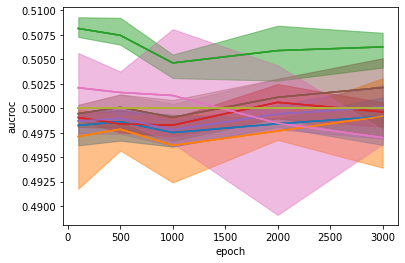

In [22]:
import seaborn as sns
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output, x="epoch", y="aucroc", hue="src", legend=False)